# Guided Neural Style Transfer

This iPython notebook is an alternative implementation of the popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)). The full project can be accessed [HERE](https://github.com/EWKnudsen/Guided-Neural-Style-Transfer) at GitHub.

Contributors: Esben Winther Knudsen, Sebastian Siem Bach-Nielsen & Malte L. Hølledig

In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg19 import VGG19

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


## Setting hyperparameters

We first set some hyperparameters that will be used later in the code. They have all been group here in the top in order to more easily experiment with different values. The size of the image, the weights of each loss function, the number of iterations, and RGB values of the output image.

In [2]:
height = 670
width = 670

style_weight = 5.0
total_variation_weight = 0.2

iterations = 50

color_Red   = 103.939
color_Green = 116.779
color_Blue  = 123.68

## Preprocess the chosen style and content image

The two images are first loaded. This implementation does not allow images to have a different width and height, so the images are rescaled to squares. It is therefore encouraged to crop the images before running the code. 

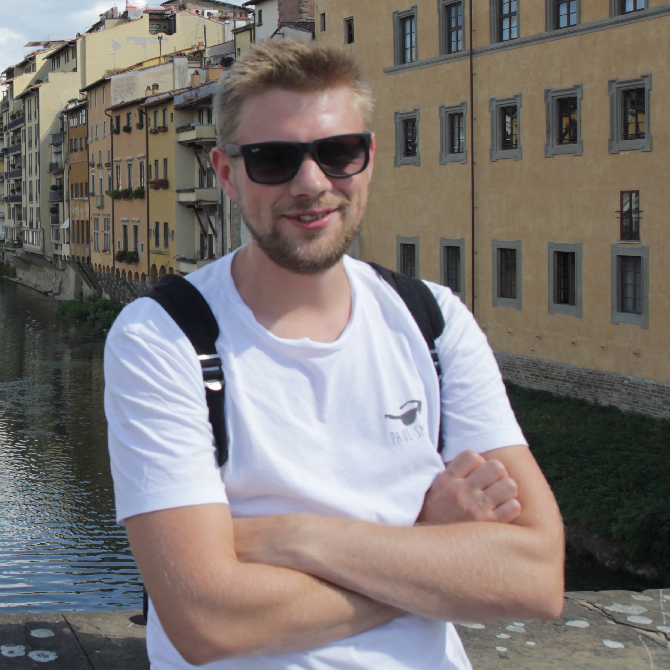

In [3]:
guide_image_path = 'images/contents/Malte.jpg'
guide_image = Image.open(guide_image_path)
guide_image = guide_image.resize((width, height))
guide_image

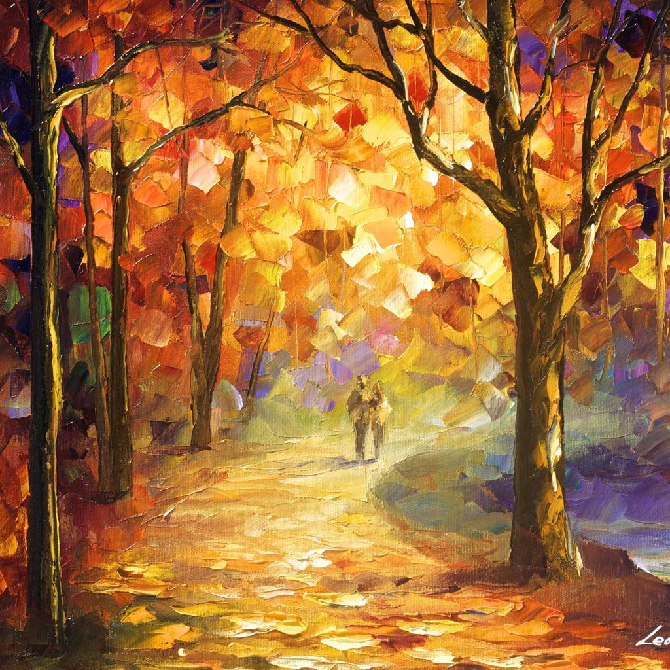

In [4]:
style_image_path = 'images/styles/forest.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

The images are then converted into a form suitable for numerical processing. An additional dimension is added, in other to later concatenate the representations of these two images into a single tensor.

In [5]:
guide_array = np.asarray(guide_image, dtype='float32')
guide_array = np.expand_dims(guide_array, axis=0)
print(guide_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 670, 670, 3)
(1, 670, 670, 3)


This format must further be transformed into something that fits the VGG Network model ([Simonyan & Zisserman, 2015](https://arxiv.org/abs/1409.1556)). 

For this, we need to perform two transformations:
1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [6]:
guide_array[:, :, :, 0] -= color_Red
guide_array[:, :, :, 1] -= color_Green
guide_array[:, :, :, 2] -= color_Blue
guide_array = guide_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= color_Red
style_array[:, :, :, 1] -= color_Green
style_array[:, :, :, 2] -= color_Blue
style_array = style_array[:, :, :, ::-1]

The arrays are then used to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the *combination* image that retains the content of the content image while incorporating the style of the style image.

The three images are then lastly concatenated into a single tensor that's suitable for processing by Keras' VGG19 model.

In [7]:
guide_image = backend.variable(guide_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, width, height, 3))

input_tensor = backend.concatenate([style_image, combination_image], axis=0)
print(input_tensor.shape)

(2, 670, 670, 3)


## Exploiting a pre-trained image classification model

The high level motivation for doing the style transfer method introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) is that convolutional neural networks (CNNs) trained for image classification have learned how to encode perceptual and semantic information about images in a similar fashion to how humans do. This opens up for the oppotunity to direcly manipulate that encoding through certain optimization functions, creating aesthetically interesting results. 

Our implementation uses the 19 layer VGG network model from [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), yet other implementations that perform style transfer also often use the 16 layer VGG. This gives our output just a slight noticeable increased quality difference yet loose a fraction of speed, due to the larger model structure thus more complex encoding.

The last fully connected layers are discarded, since we're not interested in classifying images, but only to encode each image with the model. Keras comes with a set of pretrained models, including the VGG19 model. The setting `include_top=False` in the code below, excludes the fully connected layers and the final softmax classifier.

![VGG Network Architectures](images/vgg-architecture.png)

In [8]:
model = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

layers = dict([(layer.name, layer.output) for layer in model.layers])

layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(2, 670, 670, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(2, 670, 670, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(2, 335, 335, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(2, 335, 335, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(2, 335, 335, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(2, 167, 167, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(2, 167, 167, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(2, 167, 167, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(2, 167, 167, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(2, 167, 167, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(2, 83, 83, 256) dtype=float32>,
 

Since we provided Keras with a concrete input tensor, the various TensorFlow tensors get well-defined shapes.

---

## Defining The Loss Functions
We essentially want to minimize the difference between the combination- and style image through two distinct loss functions: the *Gram Loss* and the *Total Variation Loss*. The relative importance of each loss function are determined by a scalar weight, which we defined in the start of the script: `style_weight` and `total_variation_weight`. These values are arbitrary and have been chosen after some experimentation to find weights that generate outputs that we find aesthetically pleasing.

Before calculating anything, the total loss is first initialised to zero:

In [9]:
loss = backend.variable(0.)

### The style loss

This loss function is basically the essence of the style transfer method [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) originally proposed. Is uses something called a *Gram matrix*, which is equivalent to the covariances of corresponding sets of features, capturing information about which features tend to activate together. This approach captures information about style independent of the content of an image. This is only a quick attempt to explain a quite complicated phenomenon, so we will refer you to [This paper](https://arxiv.org/abs/1606.01286) which explains the approach in more details.

The Gram matrix can be computed by reshaping the feature spaces and taking the outer product.

In [10]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

After the Gram matrices of the style and combination image is computed, the (scaled, squared) Frobenius norm of the difference between the two is calculated. And that scalar "distance" then defines the style loss, which is lastly multiplied to its weight and added to the total loss.
Note: The feature layers that have been included are chosen because we find the end results more aesthetically pleasing. However, fewer layers can be chosen to increase the execution speed or if another output is desired.

In [11]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv4', 'block4_conv4',
                  'block5_conv4']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[0, :, :, :]
    combination_features = layer_features[1, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

Encoding and decoding each image into the neural network creates some undesirable noise on the output, which can be smoothed out with some form of regularisation. For this the [total variation loss](http://arxiv.org/abs/1412.0035) is computed, multiplied by its weight, and added to the total loss. Note: Again the `total_variation_weight` can be changed in the top and be aware that only a little increase to the value may smooth out the image too much 

In [12]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Setting up the optimisation function

The goal was to treat this method as a optimisation problem where we want to minimize the local feature difference of the *combination image* with respect to the *style image*. The inputs has been transform and our two loss functions has been set up. Now the gradients of the total loss relative to the combination image will be defined, in order to use this gradient to iteratively improve upon our combination image while minimising the loss.

First the gradients is defined with respect to the loss

In [13]:
grads = backend.gradients(loss, combination_image)

An `Evaluator` class is then created that computes loss and gradients in one pass while retrieving them via two separate functions, `loss` and `grads`. This is done because `scipy.optimize` requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [14]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Finally, the optimisation problem is being solved. The output starts from the *guide image* and the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon the output (x).

The model stops iterating when the number of runs equals the *interations* integer, which was initialized in the top of the script. NOTE: Every *interations* integer over 100 is basically waste of times since it doesnt take that many runs to find convergence.

In [15]:
x = guide_array 

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, m=10, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 3.22414e+11
Iteration 0 completed in 15s
Start of iteration 1
Current loss value: 6.40963e+10
Iteration 1 completed in 12s
Start of iteration 2
Current loss value: 1.05079e+10
Iteration 2 completed in 13s
Start of iteration 3
Current loss value: 6.0045e+09
Iteration 3 completed in 13s
Start of iteration 4
Current loss value: 4.89058e+09
Iteration 4 completed in 13s
Start of iteration 5
Current loss value: 4.16997e+09
Iteration 5 completed in 13s
Start of iteration 6
Current loss value: 3.6424e+09
Iteration 6 completed in 13s
Start of iteration 7
Current loss value: 3.29534e+09
Iteration 7 completed in 13s
Start of iteration 8
Current loss value: 2.99622e+09
Iteration 8 completed in 13s
Start of iteration 9
Current loss value: 2.7602e+09
Iteration 9 completed in 13s
Start of iteration 10
Current loss value: 2.5743e+09
Iteration 10 completed in 13s
Start of iteration 11
Current loss value: 2.41711e+09
Iteration 11 completed in 13s
Start of iterati

In order to show the output image we need to inverse the transformation:


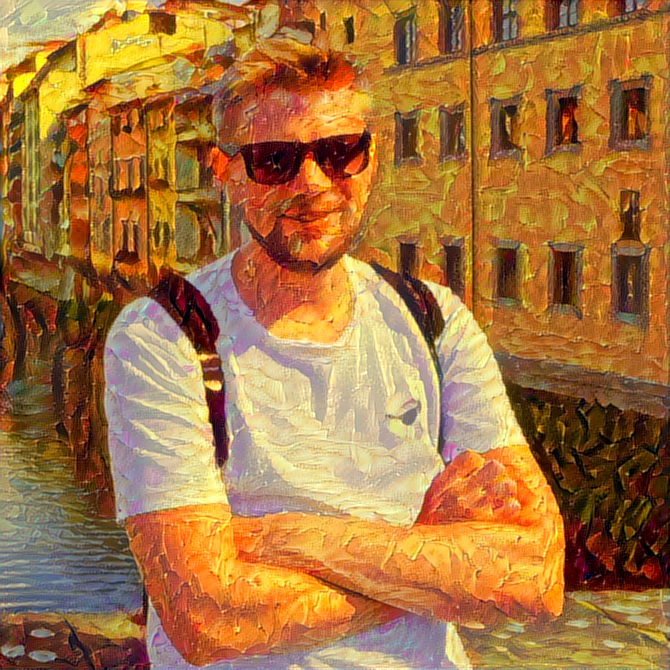

In [16]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

## Final thoughts and future works

Even though this method produces some interesting results, the speed and menory expense is quite large. The can be run on the CPU but take over 10 times as long compared to running on a GPU. Additionally if you run on the GPU, the VGG network will take up about 8Gb Video RAM, which can make the computer unusable depending on what computer you are using. We have used a GPU server where at least one TITAN X (Pascal) GPU was avaliable at a time, which made every iteration take about 20 seconds each. This slow process is caused by trying to solve an entire optimisation problem each time a new image is generated. 

Our *next project* will be to replace this method with an image transformation CNN, which in turn uses the VGG19 network as before to measure losses. However, this transformation network is trained on several images given some fixed style image (Monet, picasso, etc.), ending up with a feed-forward CNN that transfer the specific style it is trained for, to any content image. This method is about 1000th time faster to compute (after the network is trained), making suitable for Video style transfer or a simple filter tranfermation to a mobile image application.

#### Contributors:
- Esben Winther Knudsen
- Sebastian Siem Bach-Nielsen
- Malte L. Hølledig

Aalborg University Copenhagen, Medialogy 8th semester 2017 Jun.